The Code below basically finds the most important features with a function and also finds the best parameters for decision tree, it does cross validation

In [14]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import graphviz
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
import sys

# We call the csv data
df = pd.read_csv('../data/raw/winequalityN.csv')
# We fill the NaN numerical values with 0
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)

# White wine
dfW = df[df['type'] == 'white'].drop('type',axis =1)


top_Features = ['alcohol', 'volatile acidity', 'free sulfur dioxide']
# Y is our target
y = dfW['quality']
X_drop = dfW.drop('quality', axis=1)

# We split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

# We call our Class method (Decision Tree) and fit it
parameter = {
    'criterion': ['entropy', 'gini'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2', None] 
}
Decision = DecisionTreeClassifier()
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(Decision,param_grid = parameter,cv = 5)
cv.fit(X_train,y_train)


print("Best parameters found: ", cv.best_params_)
best_model = cv.best_estimator_
print("Best model: ", best_model)

Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best model:  DecisionTreeClassifier(max_depth=10)


Basically tests code with all the features and then finds the most important features using a function which then is used in the next code snippet

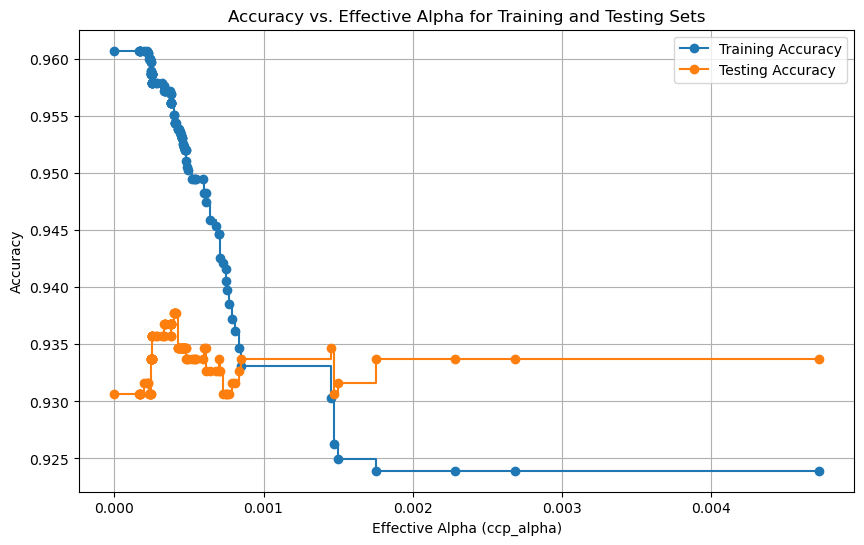

Optimal ccp_alpha: 0.00039864124877018645

Top Features by Importance:
                 Feature  Importance
1       volatile acidity    0.171300
5    free sulfur dioxide    0.155608
3         residual sugar    0.116957
10               alcohol    0.106094
6   total sulfur dioxide    0.094268
0          fixed acidity    0.084204
9              sulphates    0.068965
8                     pH    0.068735
7                density    0.063810
4              chlorides    0.043477
2            citric acid    0.026582


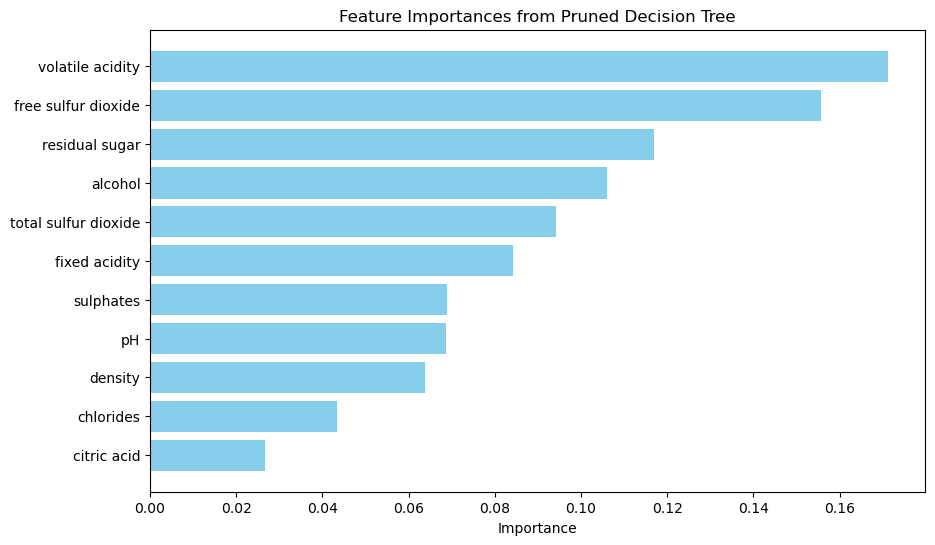

Pruned Tree Accuracy: 0.9377551020408164

Pruned Tree Classification Report:
               precision    recall  f1-score   support

        high       0.54      0.20      0.29        35
         low       0.58      0.23      0.33        30
      medium       0.95      0.99      0.97       915

    accuracy                           0.94       980
   macro avg       0.69      0.47      0.53       980
weighted avg       0.92      0.94      0.92       980



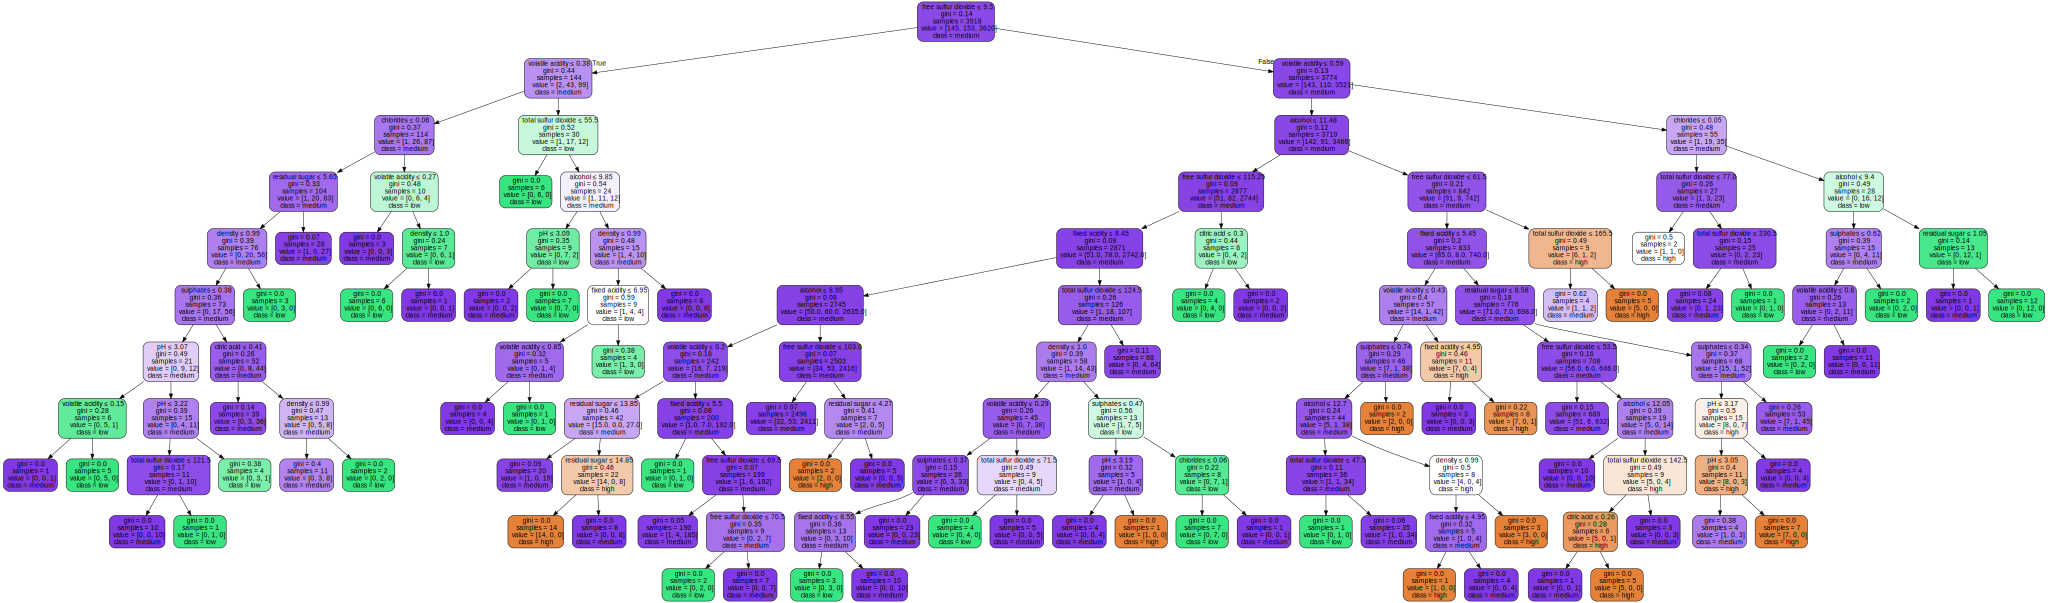

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import graphviz
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE


# We call the csv data
df = pd.read_csv('../data/raw/winequalityN.csv')
# We fill the NaN numerical values with 0
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)

# White wine
dfW = df[df['type'] == 'white'].drop('type',axis =1)

# Convert the target variable 'quality' to categorical classes
def categorize_quality(row):
    if row <= 4:
        return 'low'
    elif 5 <= row <= 7:
        return 'medium'
    else:
        return 'high'


# Apply the function to the 'quality' column to convert it to 'low', 'medium', 'high'
dfW['quality'] = dfW['quality'].apply(categorize_quality)

top_Features = ['alcohol', 'volatile acidity', 'free sulfur dioxide','citric acid']

# Y is our target
y = dfW['quality']
X_drop = dfW.drop('quality', axis=1)

X_reduced = X_drop[top_Features]

# We split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

#grab the path total leaf impurities and then grab the alphas
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clf_list = []

for ccp_alpha in ccp_alphas:
    Decision = DecisionTreeClassifier(max_depth=10,min_samples_leaf=1,min_samples_split=2 ,ccp_alpha = ccp_alpha, random_state=42)
    Decision.fit(X_train,y_train)
    clf_list.append(Decision)
    
train_scores = [clf.score(X_train, y_train) for clf in clf_list]
test_scores = [clf.score(X_test, y_test) for clf in clf_list]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Training Accuracy', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='Testing Accuracy', drawstyle="steps-post")
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Effective Alpha for Training and Testing Sets")
plt.legend()
plt.grid(True)
plt.show()

optimal_index = test_scores.index(max(test_scores))
optimal_alpha = ccp_alphas[optimal_index]
print(f"Optimal ccp_alpha: {optimal_alpha}")


pruned_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    ccp_alpha=optimal_alpha,
    random_state=42
)
pruned_tree.fit(X_train, y_train)

importances = pruned_tree.feature_importances_
feature_names = X_drop.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Pruned Decision Tree')
plt.gca().invert_yaxis()  
plt.show()


y_pred_pruned = pruned_tree.predict(X_test)

# Accuracy
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
print("Pruned Tree Accuracy:", accuracy_pruned)

# Classification Report
print("\nPruned Tree Classification Report:\n", classification_report(y_test, y_pred_pruned))



data_graph = tree.export_graphviz(
    pruned_tree, 
    out_file=None, 
    feature_names=X_drop.columns,  
    class_names=[str(i) for i in sorted(y.unique())],  
    filled=True, 
    rounded=True,  
    special_characters=True,
    precision=2
)

# Generate the Graphviz visualization
graph = graphviz.Source(data_graph)
graph

This is the final model with changing features to only be the top 4 features of most importance from the function

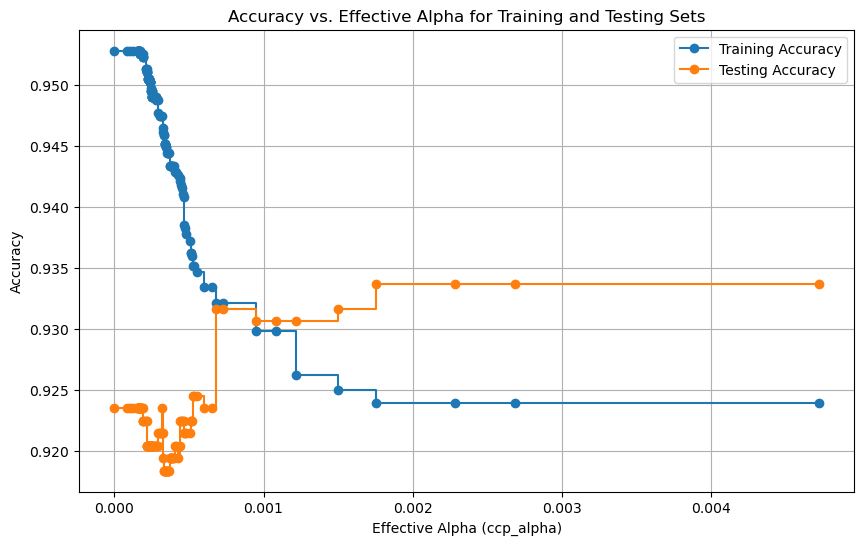

Optimal ccp_alpha: 0.0017563062549150743
Pruned Tree Accuracy: 0.9336734693877551

Pruned Tree Classification Report:
               precision    recall  f1-score   support

        high       0.00      0.00      0.00        35
         low       0.00      0.00      0.00        30
      medium       0.93      1.00      0.97       915

    accuracy                           0.93       980
   macro avg       0.31      0.33      0.32       980
weighted avg       0.87      0.93      0.90       980



c:\Users\Thind\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thind\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thind\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


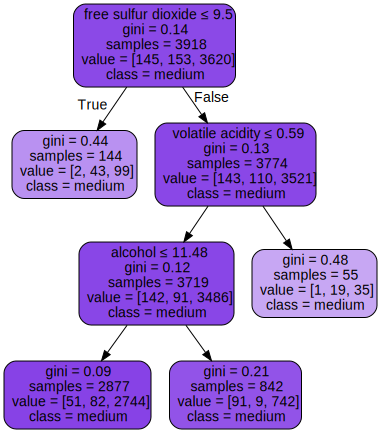

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import graphviz
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE


# We call the csv data
df = pd.read_csv('../data/raw/winequalityN.csv')
# We fill the NaN numerical values with 0
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)

# White wine
dfW = df[df['type'] == 'white'].drop('type',axis =1)

# Convert the target variable 'quality' to categorical classes
def categorize_quality(row):
    if row <= 4:
        return 'low'
    elif 5 <= row <= 7:
        return 'medium'
    else:
        return 'high'


# Apply the function to the 'quality' column to convert it to 'low', 'medium', 'high'
dfW['quality'] = dfW['quality'].apply(categorize_quality)

top_Features = ['alcohol', 'volatile acidity', 'free sulfur dioxide','citric acid']

# Y is our target
y = dfW['quality']
X_drop = dfW.drop('quality', axis=1)

X_reduced = X_drop[top_Features]

# We split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

#grab the path total leaf impurities and then grab the alphas
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clf_list = []

for ccp_alpha in ccp_alphas:
    Decision = DecisionTreeClassifier(max_depth=10,min_samples_leaf=1,min_samples_split=2 ,ccp_alpha = ccp_alpha, random_state=42)
    Decision.fit(X_train,y_train)
    clf_list.append(Decision)


train_scores = [clf.score(X_train, y_train) for clf in clf_list]
test_scores = [clf.score(X_test, y_test) for clf in clf_list]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Training Accuracy', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='Testing Accuracy', drawstyle="steps-post")
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Effective Alpha for Training and Testing Sets")
plt.legend()
plt.grid(True)
plt.show()

optimal_index = test_scores.index(max(test_scores))
optimal_alpha = ccp_alphas[optimal_index]
print(f"Optimal ccp_alpha: {optimal_alpha}")


pruned_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    ccp_alpha=optimal_alpha,
    random_state=42
)
pruned_tree.fit(X_train, y_train)


y_pred_pruned = pruned_tree.predict(X_test)

# Accuracy
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
print("Pruned Tree Accuracy:", accuracy_pruned)

# Classification Report
print("\nPruned Tree Classification Report:\n", classification_report(y_test, y_pred_pruned))


data_graph = tree.export_graphviz(
    pruned_tree, 
    out_file=None, 
    feature_names=top_Features,  
    class_names=[str(i) for i in sorted(y.unique())],  
    filled=True, 
    rounded=True,  
    special_characters=True,
    precision=2
)

# Generate the Graphviz visualization
graph = graphviz.Source(data_graph)
graph